In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/resnet50/imagenet_class_index.json
/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [2]:
import cv2
from tqdm import tqdm          #Used for the purpose of showing iterations getting loaded in bar kind of form
from random import shuffle
from zipfile import ZipFile
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

weight_loc = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'  
We'll not be using this path directly because it will cause some dimension error instead we will download weights of imagenet.
Here is the explanation:
https://stackoverflow.com/questions/60119041/failed-to-load-keras-resnet50-model-offline-using-weight-file

In [3]:
path = '../input/dogs-vs-cats-redux-kernels-edition/'

In [4]:
zip_file = glob.glob('../input/dogs-vs-cats-redux-kernels-edition/*.zip')  #return any files with .zip extension
print(zip_file)

#extract file into a temp folder
def extract_zip(file):
    with ZipFile(file,"r") as zip_ref:
        zip_ref.extractall("temp")
        
#extract both train and test1 zip
for files in zip_file:
    extract_zip(files)

['../input/dogs-vs-cats-redux-kernels-edition/test.zip', '../input/dogs-vs-cats-redux-kernels-edition/train.zip']


In [5]:
def gen_label(directory):
    label = []
    for file in os.listdir(directory):
        if (file.split('.')[0] == 'dog'):
            label.append(str(1))
        elif (file.split('.')[0] == 'cat'):
            label.append(str(0))
    return label

    
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path

label = gen_label('../working/temp/train')
train_path = get_path('../working/temp/train')
test_path = get_path('../working/temp/test')

In [6]:
df = pd.DataFrame({'filename': train_path, 'label': label})
df.head()

,filename,label
0,dog.9167.jpg,1
1,cat.199.jpg,0
2,dog.4693.jpg,1
3,cat.11421.jpg,0
4,cat.6335.jpg,0


In [7]:
train_df, valid_df = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 123)
print(train_df.shape)
print(valid_df.shape)

(20000, 2)
(5000, 2)


In [8]:
train_datagen = ImageDataGenerator(rotation_range = 10, zoom_range = 0.1, horizontal_flip = True, fill_mode = 'nearest', 
                                   width_shift_range = 0.1, height_shift_range = 0.1, preprocessing_function = preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, directory = '../working/temp/train', x_col = 'filename', y_col = 'label', target_size = (224,224),
                                              batch_size = 64, class_mode='binary')

valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

valid_gen = valid_datagen.flow_from_dataframe(valid_df, directory = '../working/temp/train', x_col = 'filename', y_col = 'label', target_size = (224,224),
                                              batch_size = 64, class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [9]:
# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'max', weights = 'imagenet'))
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False 

model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'binary_crossentropy')

94773248/94765736 [==============================] - 1s 0us/step


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
model.fit_generator(train_gen, epochs = 10, validation_data = valid_gen)

Epoch 1/10
313/313 [==============================] - 379s 1s/step - loss: 0.2119 - accuracy: 0.9549 - val_loss: 0.1106 - val_accuracy: 0.9782
Epoch 2/10
313/313 [==============================] - 377s 1s/step - loss: 0.0984 - accuracy: 0.9788 - val_loss: 0.1043 - val_accuracy: 0.9818
Epoch 3/10
313/313 [==============================] - 376s 1s/step - loss: 0.0865 - accuracy: 0.9822 - val_loss: 0.0807 - val_accuracy: 0.9850
Epoch 4/10
313/313 [==============================] - 388s 1s/step - loss: 0.0912 - accuracy: 0.9826 - val_loss: 0.1321 - val_accuracy: 0.9792
Epoch 5/10
313/313 [==============================] - 397s 1s/step - loss: 0.0605 - accuracy: 0.9865 - val_loss: 0.0730 - val_accuracy: 0.9878
Epoch 6/10
313/313 [==============================] - 399s 1s/step - loss: 0.0719 - accuracy: 0.9848 - val_loss: 0.0953 - val_accuracy: 0.9856
Epoch 7/10
313/313 [==============================] - 380s 1s/step - loss: 0.0598 - accuracy: 0.9882 - val_loss: 0.0739 - val_accuracy: 0.9880

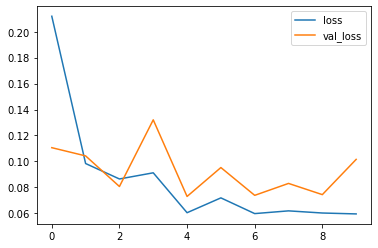

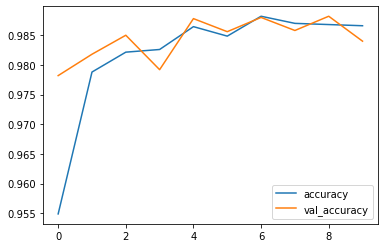

In [12]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
loss[['accuracy', 'val_accuracy']].plot()